# AWS 환경설정

* `export AWS_DEFAULT_PROFILE=ghpipeliner` 실행
* 원하는 aws profile로 잘 변경되었는지 확인
    ```
    aws s3 ls
    ```

In [1]:
import boto3
import pandas as pd
import numpy as np
import json

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta

# Load Data

In [2]:
session = boto3.session.Session(profile_name='ghpipeliner')
s3 = session.client('s3')

In [3]:
from_dt = datetime(2023, 1, 2)
to_dt = datetime(2023, 1, 14)

dt = from_dt
df = pd.DataFrame()
cols = ['candle_date_time_kst', 'open', 'high', 'low', 'close', 'volume']
while(dt <= to_dt):
    print(f"Reading {dt}...")
    for hr in range(24):
        file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=1)} candles.json'
        try:
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        except:
            file_name = f'{dt + timedelta(hours=hr, minutes=5, seconds=2)} candles.json'
            response = s3.get_object(Bucket='hb-ohlcv-buy-or-sell', Key=file_name)
        obj = json.loads(response['Body'].read().decode('utf-8'))
        df = pd.concat([df, pd.DataFrame(obj['candles'])[cols]])
    dt = dt + timedelta(days=1)
    
df.reset_index(drop=True, inplace=True)
df['candle_date_time_kst'] = df['candle_date_time_kst'].astype(dtype=np.datetime64)
df

Reading 2023-01-02 00:00:00...
Reading 2023-01-03 00:00:00...
Reading 2023-01-04 00:00:00...
Reading 2023-01-05 00:00:00...
Reading 2023-01-06 00:00:00...
Reading 2023-01-07 00:00:00...
Reading 2023-01-08 00:00:00...
Reading 2023-01-09 00:00:00...
Reading 2023-01-10 00:00:00...
Reading 2023-01-11 00:00:00...
Reading 2023-01-12 00:00:00...
Reading 2023-01-13 00:00:00...
Reading 2023-01-14 00:00:00...


,candle_date_time_kst,open,high,low,close,volume
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756
...,...,...,...,...,...,...
18715,2023-01-14 23:01:00,25982000.0,25988000.0,25969000.0,25984000.0,23.919694
18716,2023-01-14 23:02:00,25981000.0,26000000.0,25971000.0,25971000.0,20.102817
18717,2023-01-14 23:03:00,25971000.0,25980000.0,25943000.0,25948000.0,11.595073
18718,2023-01-14 23:04:00,25948000.0,25976000.0,25940000.0,25970000.0,17.004231


# Preprocess Data
* n분후 예측

In [6]:
# min-max normalizer
def normalize_data(df, ohlc, v):
    max_price = max(df[ohlc].max())
    min_price = min(df[ohlc].min())

    for col in ohlc:
        df[col] = (df[col] - min_price) / (max_price - min_price)
    
    df[v] = (df[v] - df[v].min()) / (df[v].max() - df[v].min())

    return df

In [7]:
n = 15
df['target'] = df.shift(-n)['close']
data = df.iloc[:len(df) - n]
data

,candle_date_time_kst,open,high,low,close,volume,target
0,2023-01-01 23:06:00,21088000.0,21088000.0,21088000.0,21088000.0,0.055518,21097000.0
1,2023-01-01 23:07:00,21088000.0,21099000.0,21088000.0,21088000.0,0.386599,21098000.0
2,2023-01-01 23:08:00,21088000.0,21099000.0,21088000.0,21099000.0,0.097290,21095000.0
3,2023-01-01 23:09:00,21098000.0,21099000.0,21089000.0,21091000.0,0.415292,21095000.0
4,2023-01-01 23:10:00,21099000.0,21099000.0,21090000.0,21099000.0,0.299756,21095000.0
...,...,...,...,...,...,...,...
18700,2023-01-14 22:46:00,25902000.0,25936000.0,25902000.0,25936000.0,10.017290,25984000.0
18701,2023-01-14 22:47:00,25918000.0,25933000.0,25908000.0,25910000.0,6.703668,25971000.0
18702,2023-01-14 22:48:00,25910000.0,25950000.0,25878000.0,25945000.0,24.123577,25948000.0
18703,2023-01-14 22:49:00,25940000.0,25964000.0,25936000.0,25962000.0,36.878548,25970000.0


In [8]:
data_train = data.iloc[:int(len(data) * 0.8)]
data_test = data.iloc[int(len(data) * 0.8):]

data_train = normalize_data(data_train, ['open', 'high', 'low', 'close', 'target'], 'volume')
data_test = normalize_data(data_test, ['open', 'high', 'low', 'close', 'target'], 'volume')

print('Data for Modeling: ', str(data_train.shape))
print('Unseen Data for Predictions: ', str(data_test.shape))

Data for Modeling:  (14964, 7)
Unseen Data for Predictions:  (3741, 7)


In [7]:
data_train

,candle_date_time_kst,open,high,low,close,volume,target
0,2023-01-01 23:06:00,0.028374,0.028374,0.028374,0.028374,0.001223,0.034602
1,2023-01-01 23:07:00,0.028374,0.035986,0.028374,0.028374,0.008543,0.035294
2,2023-01-01 23:08:00,0.028374,0.035986,0.028374,0.035986,0.002146,0.033218
3,2023-01-01 23:09:00,0.035294,0.035986,0.029066,0.030450,0.009178,0.033218
4,2023-01-01 23:10:00,0.035986,0.035986,0.029758,0.035986,0.006623,0.033218
...,...,...,...,...,...,...,...
14959,2023-01-12 08:25:00,0.692734,0.693426,0.685813,0.685813,0.054317,0.936332
14960,2023-01-12 08:26:00,0.685813,0.693426,0.685813,0.691349,0.016824,0.973702
14961,2023-01-12 08:27:00,0.691349,0.763322,0.685813,0.758478,0.597304,0.982007
14962,2023-01-12 08:28:00,0.758478,0.785467,0.750865,0.766782,0.381371,0.956401


In [9]:
data_test

,candle_date_time_kst,open,high,low,close,volume,target
14964,2023-01-12 08:30:00,0.003008,0.010777,0.000000,0.010777,0.013633,0.081454
14965,2023-01-12 08:31:00,0.010777,0.011779,0.010276,0.010526,0.032484,0.082957
14966,2023-01-12 08:32:00,0.010526,0.030075,0.010276,0.027569,0.171955,0.082456
14967,2023-01-12 08:33:00,0.027569,0.073935,0.026065,0.070927,0.290429,0.082957
14968,2023-01-12 08:34:00,0.070175,0.094737,0.064411,0.088972,0.131727,0.079449
...,...,...,...,...,...,...,...
18700,2023-01-14 22:46:00,0.947870,0.956391,0.947870,0.956391,0.047694,0.968421
18701,2023-01-14 22:47:00,0.951880,0.955639,0.949373,0.949875,0.031917,0.965163
18702,2023-01-14 22:48:00,0.949875,0.959900,0.941855,0.958647,0.114859,0.959398
18703,2023-01-14 22:49:00,0.957393,0.963409,0.956391,0.962907,0.175591,0.964912


# Train Model

* pycaret sample notebook: [regression tutorial](https://nbviewer.org/github/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb)

In [10]:
from pycaret.regression import *

In [11]:
exp_reg001 = setup(data=data_train, target='target', session_id=1)

,Description,Value
0,session_id,1
1,Target,target
2,Original Data,"(14964, 7)"
3,Missing Values,0
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(10474, 35)"


In [12]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0979,0.0152,0.1232,0.3515,0.0910,0.4528,0.0240
gbr,Gradient Boosting Regressor,0.1087,0.0169,0.1300,0.2773,0.0961,0.5130,0.1330
knn,K Neighbors Regressor,0.0922,0.0170,0.1305,0.2715,0.0963,0.4317,0.0450
ridge,Ridge Regression,0.1151,0.0188,0.1369,0.1985,0.1013,0.5498,0.0050
lar,Least Angle Regression,0.1151,0.0188,0.1369,0.1985,0.1013,0.5492,0.0060
br,Bayesian Ridge,0.1152,0.0188,0.1370,0.1982,0.1013,0.5535,0.0150
ada,AdaBoost Regressor,0.1188,0.0189,0.1376,0.1912,0.1021,0.5916,0.0280
lr,Linear Regression,0.1158,0.0189,0.1376,0.1910,0.1018,0.5528,0.5140
rf,Random Forest Regressor,0.0944,0.0191,0.1382,0.1843,0.1018,0.4545,0.4200
huber,Huber Regressor,0.1131,0.0192,0.1384,0.1810,0.1026,0.5582,0.0280


In [13]:
lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0983,0.0148,0.1217,0.3759,0.0900,0.4264
1,0.0988,0.0154,0.1242,0.3539,0.0916,0.4504
2,0.0992,0.0156,0.1248,0.3108,0.0921,0.6010
3,0.0979,0.0148,0.1216,0.3718,0.0896,0.4318
4,0.0970,0.0152,0.1232,0.3302,0.0918,0.4525
5,0.0940,0.0145,0.1204,0.3672,0.0888,0.4224
6,0.0992,0.0154,0.1242,0.3421,0.0914,0.4196
7,0.0984,0.0160,0.1265,0.3189,0.0937,0.4629
8,0.0983,0.0151,0.1227,0.3600,0.0903,0.4065


In [14]:
tuned_lgbm = tune_model(lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1151,0.0187,0.1368,0.2116,0.1019,0.5929
1,0.1132,0.0190,0.1377,0.2062,0.1020,0.5920
2,0.1129,0.0185,0.1361,0.1806,0.1006,0.7426
3,0.1118,0.0184,0.1356,0.2181,0.1006,0.5585
4,0.1118,0.0183,0.1351,0.1941,0.1007,0.5614
5,0.1100,0.0181,0.1345,0.2098,0.0994,0.5432
6,0.1128,0.0188,0.1371,0.1978,0.1011,0.5388
7,0.1108,0.0186,0.1364,0.2074,0.1015,0.5939
8,0.1128,0.0185,0.1360,0.2149,0.1004,0.5482


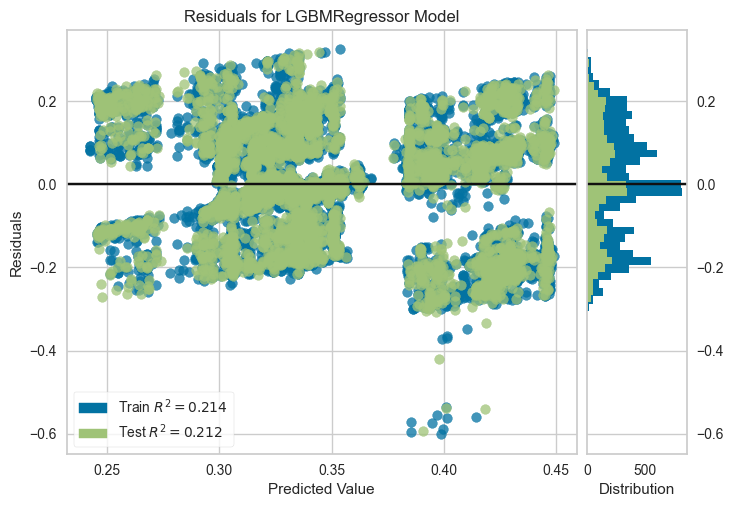

In [15]:
plot_model(tuned_lgbm)

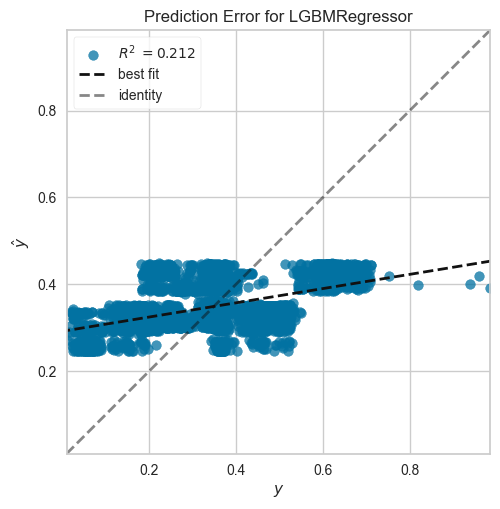

In [16]:
plot_model(tuned_lgbm, plot = 'error')

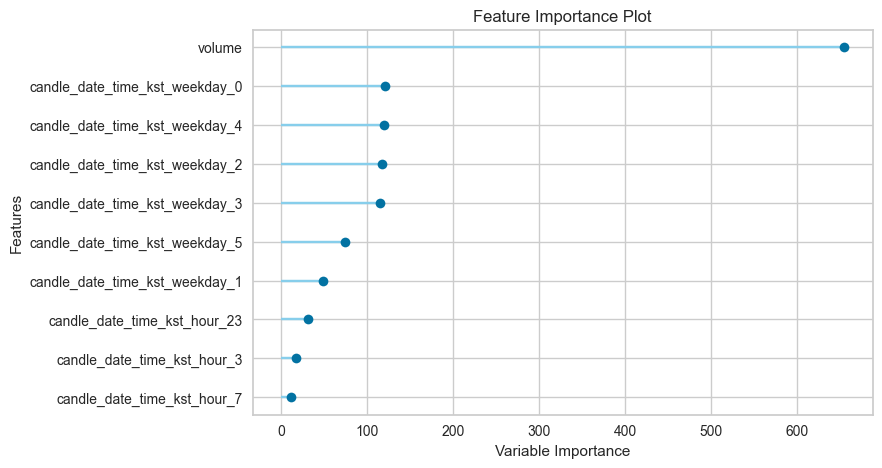

In [17]:
plot_model(tuned_lgbm, plot='feature')

In [18]:
final_lgbm = finalize_model(tuned_lgbm)
print(final_lgbm)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b

In [19]:
unseen_predictions = predict_model(final_lgbm, data=data_test)
unseen_predictions.head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2558,0.1057,0.3251,-0.3609,0.2134,0.6960


,candle_date_time_kst,open,high,low,close,volume,target,Label
14964,2023-01-12 08:30:00,0.003008,0.010777,0.000000,0.010777,0.013633,0.081454,0.412110
14965,2023-01-12 08:31:00,0.010777,0.011779,0.010276,0.010526,0.032484,0.082957,0.397313
14966,2023-01-12 08:32:00,0.010526,0.030075,0.010276,0.027569,0.171955,0.082456,0.379643
14967,2023-01-12 08:33:00,0.027569,0.073935,0.026065,0.070927,0.290429,0.082957,0.379225
14968,2023-01-12 08:34:00,0.070175,0.094737,0.064411,0.088972,0.131727,0.079449,0.380033
14969,2023-01-12 08:35:00,0.088471,0.094737,0.073935,0.078195,0.162200,0.079449,0.379643
14970,2023-01-12 08:36:00,0.074937,0.085213,0.074937,0.082206,0.171540,0.083208,0.379643
14971,2023-01-12 08:37:00,0.079950,0.095489,0.079449,0.093233,0.163598,0.084461,0.379643
14972,2023-01-12 08:38:00,0.094987,0.094987,0.082456,0.087719,0.066195,0.085464,0.394702
14973,2023-01-12 08:39:00,0.087719,0.087719,0.070426,0.075689,0.069916,0.088221,0.394436


In [20]:
from pycaret.utils import check_metric

In [21]:
check_metric(unseen_predictions['target'], unseen_predictions['Label'], 'R2')

-0.3609

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

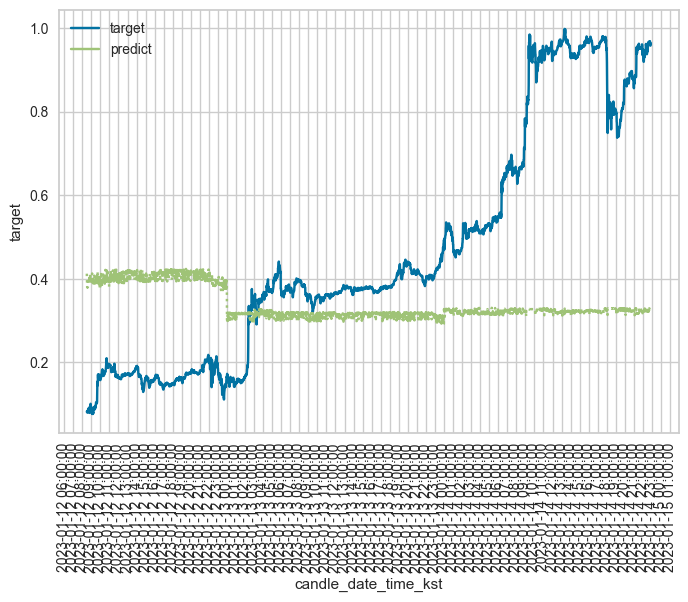

In [23]:
fig, ax = plt.subplots()

sns.lineplot(data = unseen_predictions, x='candle_date_time_kst', y='target', label='target', ax=ax)
sns.lineplot(data = unseen_predictions, x='candle_date_time_kst', y='Label', label='predict', ax=ax)

ax.lines[1].set_linestyle(":")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
ax.set_xticklabels(labels=ax.xaxis.get_ticklabels(), rotation=90)
fig.show()